# Coursework Q2 - Barrier Option Fitting using TensorFlow


Use an ANN to approximate the price and delta of a European barrier option

### Instructions

Use a neural network to approximate the value of an up and out European call barrier option. 

1) Explore to see how best to parametrise the option price and how complex the neural network needs to be to approximate it.

You can either implement the up and out call option pricer yourself from online code or take code from financepy. It is here.

https://github.com/domokane/FinancePy/blob/master/financepy/products/equity/equity_barrier_option.py

Probably best not to use financepy directly as the interface requires Dates and Curves which will slow it down. One day I will factor out the core code into a separate module. But not yet. 

2) Calculate the delta of the option from the trained neural network and compare it to the actual delta. How good is it ? How might it be improved. 

3) Make sure you explain your steps and results clearly. I expect to see a summary and conclusions section at the end.


## Solution

<span style="color:red;">Disclaimers:</span> I realized, unfortunatly too late, that I made a mistake in the computation of the call prices. I applied the fonction "up_and_out_value" (which calculate the option value) only at maturity and I should have done it at every time step... This is a big error since I went throught MC simulations in order to compute this path dependent price, but I did not apply my function correctly. 

2nd point: I only trained the model to predict the price for every level of the underlying price, and so, I beleive, the model has to know the option delta. 

<span style="color:red;">------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Definition: 

An up-and-out call option is an option that ceases to exist only if SMax > B where S0 < B, with B a barrier level determined at the creation of the option.

As an up-and-out call option is path dependent (because it can ceases if the stock prices crosses the barrier level at every moment), we first need to simulate the stock price.


<b><u>Step 1: Creation a the dataset</u></b>

The first thing we need to do before constructing our model is to generate a dataset on which we will train our model. 

We have thought about 2 different options: 
- Calculating the up-and-out call price via a partial derivative equations approach
- Calculating it via Monte Carlo simulations

We choose the second approach as fewer hypothesis were needed and the computational cost for generating our data remained acceptable

<b><u>Inputs:</u></b>
Stock price (S)
Strike price (K)
Risk-free rate (r)
Time to maturity (T)
Volatility (sigma)
Barrier level (B)

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from numpy import exp, sqrt
from numpy.random import normal, seed
from tqdm import trange
from random import randint, uniform
from joblib import Parallel, delayed

from financepy.products.equity import equity_barrier_option

pd.options.mode.chained_assignment = None

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:42 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [342]:
def generate_stock_prices(S_0, T, r, sigma) -> float: 
    """
    Generate the terminal share price following a diffusion model according to Black and Scholes.
    """

    return S_0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * normal())


def up_and_out_value(S_T, K, B, T, r) -> float:
    """
    Returns the PV of an up and out call option
    """

    if S_T > B: return 0
    else: return max(S_T - K, 0) * exp(-r * T)

In [319]:
seed(111)

# Up-and-Out call inputs

S0 = 100
K = 100
B = 150
r = 0.02
T = 2
sigma = 0.2
dt = 1/260

# Monte Carlo simulation parameters
n_mc_sim = 1000
n_steps = int(T / dt) # daily movements

In [269]:
stock_prices = np.zeros((n_mc_sim, n_steps))

# Initialisation of starting price
stock_prices[:,0] = S0

# Generate stock price pathes
for i in range(n_mc_sim): 
    for j in range(1, n_steps): 
        stock_prices[i,j] = generate_stock_prices(stock_prices[i, j-1], dt, r, sigma)

Text(0.5, 1.0, 'Stock Price pathes')

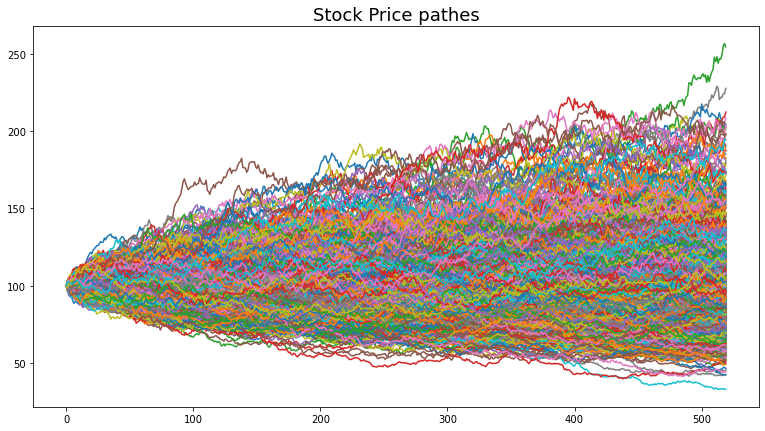

In [162]:
plt.figure(figsize=(13, 7))

for i in range(n_mc_sim): 
    plt.plot(stock_prices[i])

plt.title("Stock Price pathes", fontsize=18)

In [61]:
option_values = list(map(lambda x: up_and_out_value(x, K, B, T, r), stock_prices[:,-1]))

In [63]:
up_and_out_call_price = np.mean(option_values)

In [64]:
up_and_out_call_price

7.306496450078034

So now that we are able to price one up-and-out call option, lets simulate 1000 up-and-out call options to create a dataset in which we will train our model

In [399]:
def generate_up_and_out_call_price(n_mc_sim = 1000):

    """
    Generate a fake up and out call option and returns its parameters and price. 
    Underlying stocks prices follows a log normal process. No dididend, constant volatility and interest rate curve.

    n_mc_sim: int, the number of MC simulation. Default is 1000.
    """ 
    
    S0 = randint(30, 200) # Underlying intial price is randomly choosen between 30 and 200 included (it is arbitrary)
    K = S0 + randint(0, 50) # The Strike price should be above or equal to initial underlying price          
    B = K + randint(1, 80)  # The barrier level should be above the strike and underlying prices otherwise the product doesn't exists
    T = randint(1, 20)
    sigma = uniform(0.001, 0.4)
    r = uniform(-0.03, 0.12) # We allow for extrem interest rate values and try to keep them realistic
    
    dt = 1/260
    n_steps = int(T / dt)

    # Initialisation of starting price
    stock_prices = pd.DataFrame(np.zeros((n_mc_sim, n_steps)))
    stock_prices.iloc[:,0] = [S0]*n_mc_sim
    
    
    for i in range(1, n_steps): 
        stock_prices.iloc[:,i] = stock_prices.iloc[:,i-1].apply(lambda x: generate_stock_prices(x, dt, r, sigma))
    
    option_values = list(map(lambda x: up_and_out_value(x, K, B, T, r), stock_prices.iloc[:,-1]))
    up_and_out_call_price = np.mean(option_values)

    return S0, K, B, T, sigma, r, up_and_out_call_price

In [401]:
# Test
generate_up_and_out_call_price()

(81, 119, 144, 9, 0.2877851642903817, 0.017862073759356827, 0.5676117614414752)

<span style="color:red;">You should not run the next cell as it takes a (very) long time to run</span>


In [407]:
n_rows = 1000
col_names = ["S0", "K", "B", "T", "sigma", "r", "Price"]
dataset = pd.DataFrame(columns=col_names)

for i in trange(n_rows): 
    
    new_product = generate_up_and_out_call_price()
    dataset = pd.concat([dataset, pd.DataFrame.from_records([new_product], columns=col_names)])

dataset.to_csv('dataset.csv')

100%|██████████| 1000/1000 [5:45:58<00:00, 20.76s/it]    


In [416]:
dataset = pd.read_csv('dataset.csv', sep=';')

In [417]:
dataset.head()

,S0,K,B,T,sigma,r,Price
0,187,198,273,2,0.095572,0.090340,19.882333
1,128,154,232,16,0.297447,0.083464,1.138009
2,104,145,178,17,0.392059,0.071538,0.171863
3,183,186,203,15,0.193069,0.020727,0.249050
4,71,96,155,16,0.159242,0.012600,3.962104


## Data Visualization

array([[<AxesSubplot:title={'center':'S0'}>,
        <AxesSubplot:title={'center':'K'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'r'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

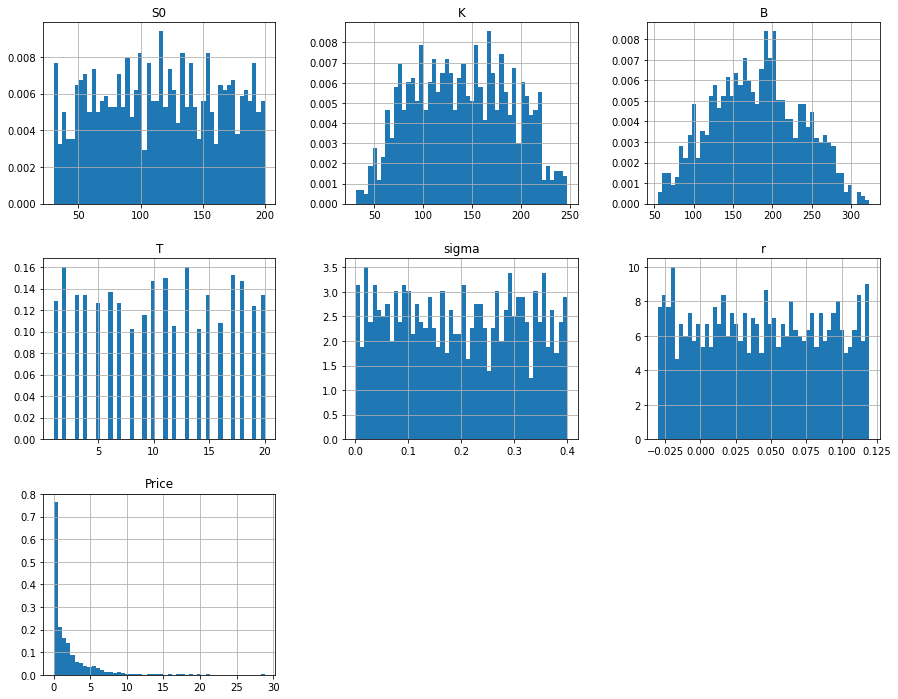

In [420]:
dataset.hist(bins=50, density=True, sharex=False, sharey=False, xlabelsize=10, ylabelsize=10, figsize=(15,12))

We can see that the price has an interesting distribution with a spike at $0$ due to all of the OTM options plus the upside barrier. Strike and barrier are Gaussian distributed, the time (T), volatility (sigma) and interest rate are uniformally distributed.

## Data Preparation and Analysis

In [440]:
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [441]:
Y = dataset.Price
X = dataset.drop('Price', axis=1)

In [442]:
X

,S0,K,B,T,sigma,r
0,187,198,273,2,0.095572,0.090340
1,128,154,232,16,0.297447,0.083464
2,104,145,178,17,0.392059,0.071538
3,183,186,203,15,0.193069,0.020727
4,71,96,155,16,0.159242,0.012600
...,...,...,...,...,...,...
995,152,192,199,11,0.261369,0.024187
996,76,93,153,16,0.142295,0.028319
997,189,235,283,1,0.317129,-0.023359
998,154,174,222,14,0.178132,-0.018169


In [443]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Spot','Strike', 'Barrier', 'Time', 'Vol', 'Rate'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Time,84.635555
Barrier,34.538809
Vol,23.805240
Spot,1.604440
Rate,0.407159
Strike,0.047822


## Buiding our model

In [444]:
import tensorflow as tf
from tensorflow import keras

In [445]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

Model Architecture: 

This is a sequential neural network with three layers: two hidden dense layers with 100 neurons each, using the ReLU activation function, and an output dense layer with one neuron and linear activation function. The optimizer is Adam (we chose Adam optimizer since we had issues with SGD), and the loss function is mean squared error. The model is trained for 100 epochs on training data and evaluated using validation data.

In [449]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

tf_model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1)
])

#We choose Adam optimizer since we had NaN with SGD
tf_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=1e-4))

res = tf_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 48.9516 - val_loss: 7.2420
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 10.3023 - val_loss: 5.6689
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 7.1599 - val_loss: 6.2151
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 6.7728 - val_loss: 5.2648
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 6.9226 - val_loss: 5.3934
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 6.4626 - val_loss: 4.9374
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 8.6939 - val_loss: 9.0745
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 7.1054 - val_loss: 5.0028
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 6.2705 - val_loss: 5.2088
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 6.9392 - val_loss: 4.8303
Epoch 

## Examination of the Fit

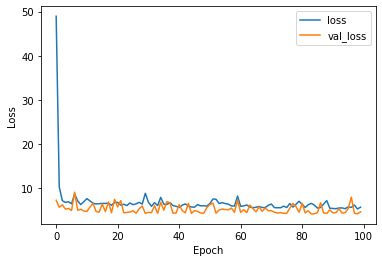

In [452]:
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

As we can see our loss function converges fast but our val_loss is not really stable.

In [488]:
def generate_real_and_predicted_data():

    real_prices = []
    predicted_prices = []

    for i in range(40):
        real_data = generate_up_and_out_call_price()
        S0 = real_data[0]
        K = real_data[1]
        B = real_data[2]
        T = real_data[3]
        sigma = real_data[4]
        r = real_data[5]
        
        real_prices.append(real_data[6])

        X = np.array([S0, K, B, T, sigma, r]).reshape(-1,1).transpose()
        predicted_prices.append(tf_model.predict(X))
    
    return real_prices, predicted_prices

In [489]:
data = generate_real_and_predicted_data()

1/1 [==============================] - 0s 10ms/step


In [514]:
X = data[0]
Y = [x[0][0] for x in data[1]]

Text(0.5, 1.0, 'Comparaison between real and predicted data')

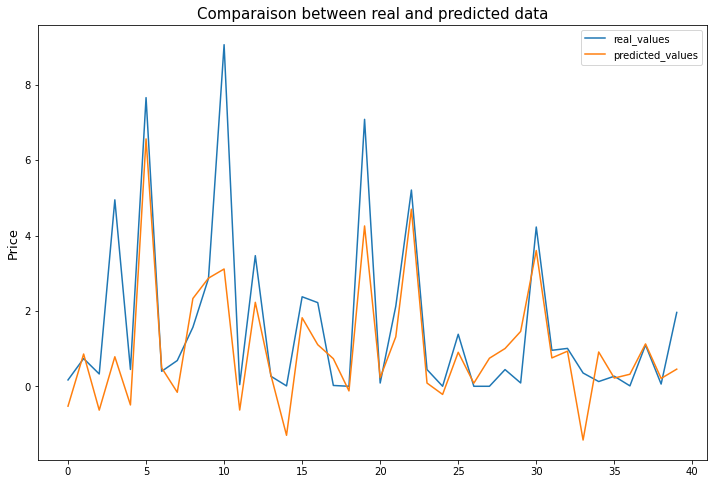

In [529]:
plt.figure(figsize=(12,8))
plt.plot(X, label='real_values')
plt.plot(Y, label='predicted_values')
plt.legend()
plt.ylabel("Price", fontsize=13)
plt.title("Comparaison between real and predicted data", fontsize=15)

<b><u>Conclusion:</u></b>

Our model manages to fit quite weel our real data.  It keeps it shape but tends to underestimate the real data as we can see. 
As it is able to compte the price for every underlying price level, it is able to know the option delta.

